## Chest X-Ray Prediction

## Data Understanding
- The data comes from chest X-ray images (anterior-posterior) that were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou.
- This data is composed of three different pieces:
 1. Train set
 2. Test set
 3. Validation set
- A limitation to the data set as a whole is that the images are from a very specific age range. This might create some issues with the data.

### Preparing the Data
- Importing relevant libraries to operate on the data.
- Defining the directories for the data.
- Creating a function to help visualize our model results. 

In [100]:
# Some basic imports to start out.
# There may be more imports along the way depending on how the data is explored.
# For Visualization
import matplotlib.pyplot as plt 
# For handling different arrays.
import numpy as np   
# For handling the data.
import pandas as pd             

In [101]:
#Define Directories for train, test & Validation Set
train_path = 'chest_xray/train/'
test_path = 'chest_xray/test/'
valid_path = 'chest_xray/val/'

In [102]:
# Defining results from a visualization function.
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

## Parameters
- The batch refers to the number of training examples utilized in one iteration.
- The dimension of the images we are going to define are 500x500.
- The dimension size of 500 or more with a batch size greater than 16 may result in a crash as the RAM gets completely used in such cases. 
- A lower dimension size with greater batch size is one of the options to try.

In [103]:
# Define some often used standard parameters
batch_size = 16 
img_width = 500
img_height = 500

## Creating an Image Data Generator
- We will increase the size of the image training dataset artificially by performing an Image Augmentation technique. Image Augmentation expands the size of the dataset by creating a modified version of the existing training set images that helps to increase dataset variation and ultimately improve the ability of the model to predict new images.
- The image generator is for:
 1. Train set
 2. Test set

In [104]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale = 1./255,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True)

test_data_gen = ImageDataGenerator(rescale = 1./255)

## Loading up the Images
- The Image Data Generator has a class known as flow from the directory which reads the images from the folders containing the images.
- This will return the DirectoryIterator typetensorflow.python.keras.preprocessing.image.DirectoryIterator.

In [105]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
# Shuffle is set to as False so we can later compare it with predicted values without having indexing problem.
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,  
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Images
- This is a simple preview of some of the train set images obtained from using Data Augmentation.

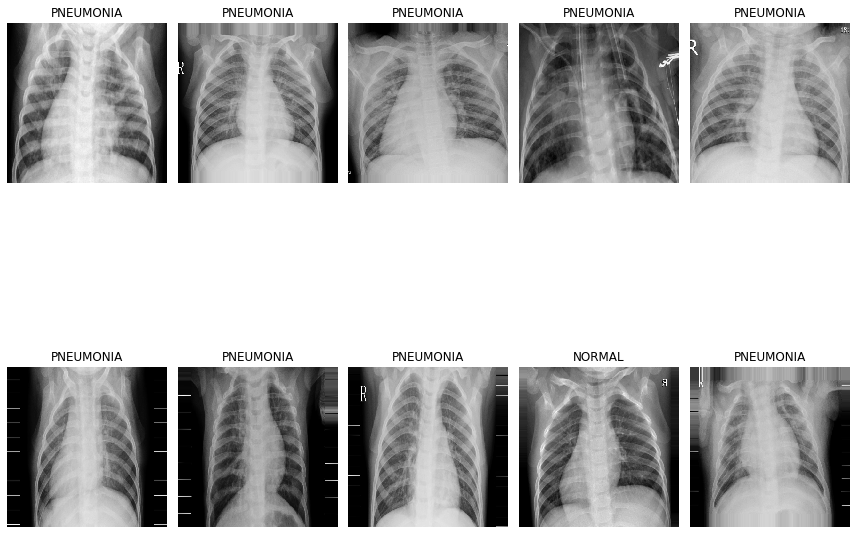

In [106]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

## CNN
- CNN architecture is based on layers of convolution. 
- The convolution layers receive input and transform the data from the image and pass it as input to the next layer. 
- The transformation is known as the operation of convolution.
- It is necessary to define the number of filters for each convolution layer. 
- These filters detect patterns such as edges, shapes, curves, objects, textures, or even colors. 
- The more sophisticated patterns or objects it detects are more deeply layered.

In [8]:
# Imports that will allow a CNN architecture to be created.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [150]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(activation = 'relu', units = 100))
model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(activation = 'sigmoid', units = 1))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [151]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 249, 249, 32)      0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1984032)           0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               198403300 
_________________________________________________________________
dense_33 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
Total params: 198,410,149
Trainable params: 198,410,149
Non-trainable params: 0
________________________________________

In [ ]:
model1 = model.fit_generator(train,
                         steps_per_epoch = 100,
                         epochs = 5,
                         validation_data = valid,
                         validation_steps = 624)

Epoch 1/5
 12/100 [==>...........................] - ETA: 1:53 - loss: 3.9005 - accuracy: 0.6094

In [145]:
test_a = model.evaluate(test)
print('The testing accuracy is :',test_a[1]*100, '%')

39/39 [==============================] - 8s 199ms/step - loss: 52.9119 - accuracy: 0.6250
The testing accuracy is : 62.5 %


In [146]:
preds1 = model.predict(test,verbose=1)

39/39 [==============================] - 8s 199ms/step


Test loss: 52.9118537902832
Test accuracy: 0.625


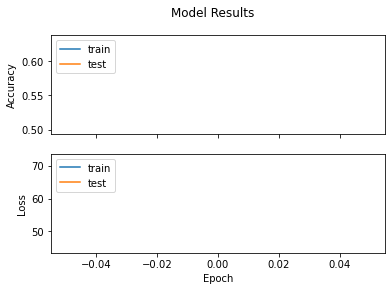

In [147]:
test_a = model.evaluate_generator(test, 100)
print("Test loss:", test_a[0])
print("Test accuracy:", test_a[1])

visualize_training_results(model1)

In [148]:
prediction = preds1.copy()
prediction[prediction <= 0.5] = 0
prediction[prediction > 0.5] = 1

<AxesSubplot:>

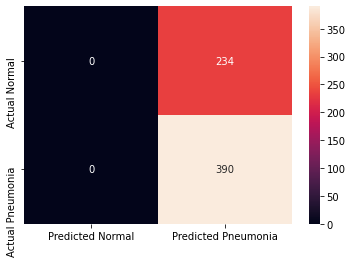

In [149]:
from sklearn.metrics import classification_report,confusion_matrix
cm1 = pd.DataFrame(data=confusion_matrix(test.classes, prediction, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm1,annot=True, fmt="d")

### Important things to think about before starting to build a CNN model:
1. Always begin with a lower filter value such as 32 and begin to increase it layer wise. (find out why?)
2. Construct the model with a layer of Conv2D followed by a layer of MaxPooling.
3. The kernel_size is a preferred odd number like 3x3.
4. Tanh, relu, etc. can be used for an activation function, but relu is the most preferred choice.
5. (input_shape) takes three arguments, the images width & height and dimension as color channel.
6. Flatten the input after the CNN layers and then add ANN layers.
7. Use the activation function as softmax for the last layer. If the problem is more than 2 classes, define units as the total number of classes and use sigmoid for binary classification and set unit to 1.

In [72]:
cnn = Sequential()
# Starting out with a lower filter of 32.
# Max Pooling simply says to the Convolutional Neural Network that we will carry forward only that information,
# if that is the largest information available amplitude.
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
# Increasing the filter to 64.
cnn.add(Conv2D(64, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
# Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. 
# We flatten the output of the convolutional layers to create a single long feature vector.
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## CNN Summary
- Now that we have developed the model let's see what is going on!

In [73]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 58, 58, 64)       

## Interpretation of the Model
- Plotting CNN architecture.

In [74]:
# Hyperparameters of Conv2D
Conv2D(filters=2, kernel_size=1,
    strides=(1, 1),
    padding="valid",
    activation=None,
    input_shape=(img_height, img_width, 3)
    )
# Hyperparameters of MaxPooling2D 
MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid"
    )

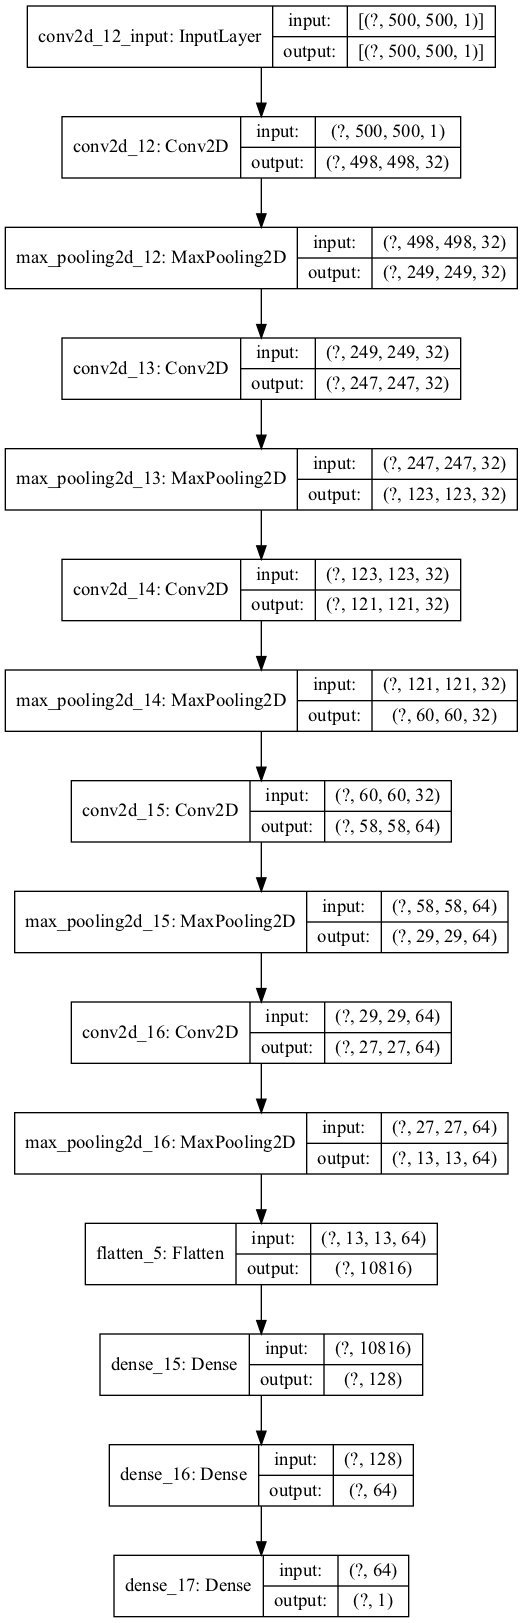

In [75]:
!pip install pydot
import graphviz
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

## Fitting the Model
- EarlyStopping is called to stop the epochs based on some metric (monitor) and conditions (mode, patience). 
- It helps to avoid overfitting the model. 
- We are telling the model to stop based on val_loss metric, we need it to be a minimum. 
- (patience) says that after a minimum val_loss is achieved during the next iterations if the val_loss increases in any of the 3 iterations then the the training will stop at that epoch.

In [76]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

## Assigning Class Weights
- It is good practice to assign class weights. 
- It emphasizes the weight of the minority class in order for the model to learn from all classes equally.

In [77]:
train.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [78]:
train

In [79]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=np.unique(train.classes), y=train.classes)
cw = dict(zip(np.unique(train.classes), weights))
print(cw)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [80]:
#cnn_model = cnn.fit(train, epochs=1, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

In [81]:
#cnn_model = cnn.fit(train, epochs=1, validation_steps=20, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

In [83]:
cnn_model = cnn.fit_generator(train,
                         steps_per_epoch = 100,
                         epochs = 10,
                         validation_data = valid,
                         validation_steps = 624)

Epoch 1/10
100/100 [==============================] - 137s 1s/step - loss: 0.4586 - accuracy: 0.7894 - val_loss: 0.6807 - val_accuracy: 0.7500
Epoch 2/10
100/100 [==============================] - 2055s 21s/step - loss: 0.2724 - accuracy: 0.8838
Epoch 3/10
100/100 [==============================] - 264s 3s/step - loss: 0.2712 - accuracy: 0.8963
Epoch 4/10
100/100 [==============================] - 263s 3s/step - loss: 0.2357 - accuracy: 0.9106
Epoch 5/10
100/100 [==============================] - 261s 3s/step - loss: 0.2551 - accuracy: 0.8938
Epoch 6/10
100/100 [==============================] - 1120s 11s/step - loss: 0.2022 - accuracy: 0.9187
Epoch 7/10
100/100 [==============================] - 138s 1s/step - loss: 0.2078 - accuracy: 0.9206
Epoch 8/10
100/100 [==============================] - 236s 2s/step - loss: 0.1822 - accuracy: 0.9231
Epoch 9/10
100/100 [==============================] - 138s 1s/step - loss: 0.2157 - accuracy: 0.9156
Epoch 10/10
100/100 [========================

## Defining the Results of the Visualization Function

Test loss: 0.33308395743370056
Test accuracy: 0.8589743375778198


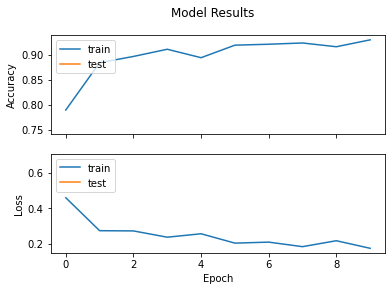

In [116]:
test_accu = cnn.evaluate_generator(test, 100)
#test_accu = cnn.evaluate(test_set, len(validation_generator), verbose=0)
print("Test loss:", test_accu[0])
print("Test accuracy:", test_accu[1])

visualize_training_results(cnn_model)

## Evaluate
- Find the models accuracy.
- Predicting the test dataset.
- Taking a peak at some of the performance measurement metrics in detail to evaluate our model.

In [85]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 12s 319ms/step - loss: 0.3331 - accuracy: 0.8590
The testing accuracy is : 85.89743375778198 %


In [118]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 13s 329ms/step


- The activation function of the last layer is sigmoid.
- This allows the model to give a prediction in the 0 to 1 range and not an exact classification as 0 or 1. 
- So we categorize all the values in the 0.5 to 1 range as 0 and less than 0.5 as 1. 
- Note: 0 denotes a normal case and 1 denotes a case of pneumonia.

In [87]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

## Confusion Matrix
- The upper left (true positive) denotes the number of images correctly predicted as normal cases.
- The bottom right (true negative) denotes the correctly predicted number of images as cases of pneumonia. 
- The upper right denotes the number of incorrectly predicted images but were actually normal cases.
- The lower left denotes the number of incorrectly predicted images that were actually pneumonia cases.

<AxesSubplot:>

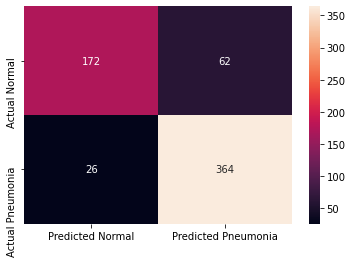

In [88]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True, fmt="d")

## Classification Report
- Precision = TruePositives / (TruePositives + FalsePositives)
 - The precision score explains how precise/accurate your model is out of those predicted positive. Meaning, how many of them are actually positive.
- Recall = TruePositives / (TruePositives + FalseNegatives)
 - Recall calculates how many of the actual positives our model captured through labeling them as positive (true positive).
- F1 = (2 * Precision * Recall) / (Precision + Recall)
 - F1 Score can be a better measure to use if we need to seek a balance between precision and recall. Especially if there is an uneven class distribution (large number of actual negatives).

In [89]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.87      0.74      0.80       234
   PNEUMONIA       0.85      0.93      0.89       390

    accuracy                           0.86       624
   macro avg       0.86      0.83      0.84       624
weighted avg       0.86      0.86      0.86       624



## Visualizing Some of the Predicted Values

In [90]:
# This code extracts the images from the test data iterator without shuffling the sequence.
# x contains image array and y has labels 
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(624, 500, 500, 1)
(624,)


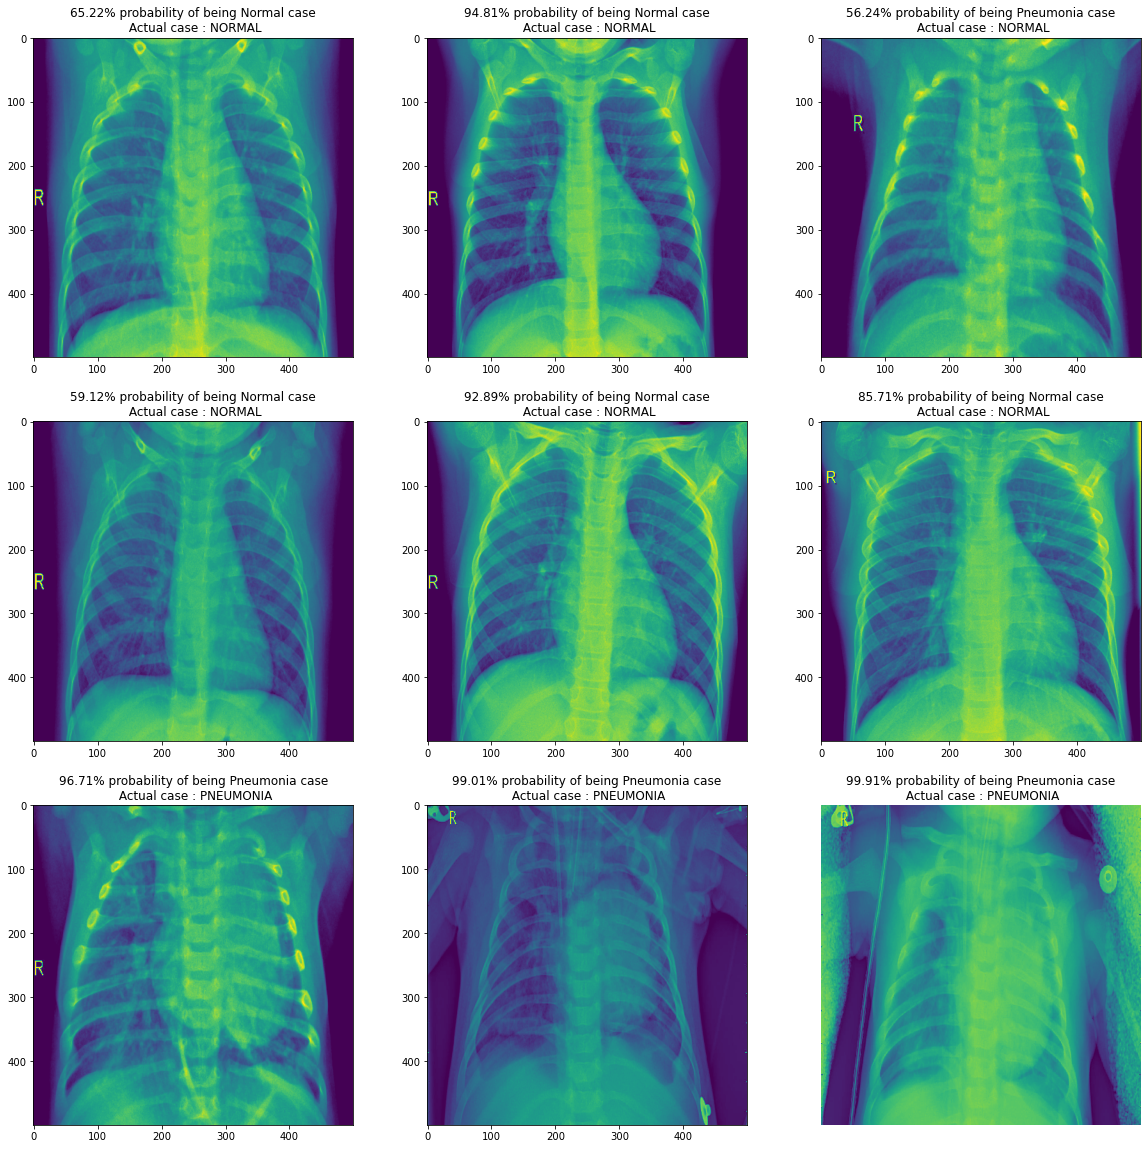

In [96]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
    plt.subplot(3, 3, (i-228)+1)
    if preds[i, 0] >= 0.5: 
        out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
    else: 
        out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
    plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
    plt.imshow(np.squeeze(x[i]))
plt.axis('off')
plt.show()

## Testing on a Random Sample (for fun)
- Picking a random image out (just googled chest x-ray).
- Processing the image.
- Predicting from the random image obtained.
- Visualizing the random sample.

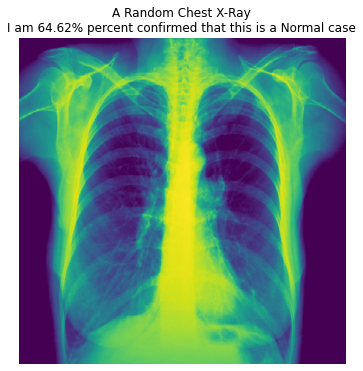

In [95]:
# Testing a random Chest X-Ray from the internet.
random_path = 'chest_xray/X-Ray-Chest-random-32202353-500-400.jpg'
from tensorflow.keras.preprocessing import image
random_img = image.load_img(random_path, target_size=(500, 500), color_mode='grayscale')

# Preprocessing the image.
pp_random_img = image.img_to_array(random_img)
pp_random_img = pp_random_img/255
pp_random_img = np.expand_dims(pp_random_img, axis=0)

# Predicting the accuracy of the random chest x-ray.
random_preds= cnn.predict(pp_random_img)

# Visualize the random sample.
plt.figure(figsize=(6,6))
plt.axis('off')
if random_preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(random_preds[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-random_preds[0][0]))
plt.title("A Random Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_random_img))
plt.show()